# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review
Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [1] Reading Data 

### Loading the data 

The dataset is available in two forms

.csv file
SQLite Database
In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".



In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

# [2] Exploratory Data Analysis

We already done EDA and prepossing of data and stored it in final.sqlite. This we will use it directly so now we don't need to do EDA and preprocessing. In Preprocessing section, we are going to use our saved final.sqlite directly.

# [3] Preprocessing

In [2]:
#loading preprocessed data which was stored in final dataset
con = sqlite3.connect('final.sqlite') 

In [3]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [4]:
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [5]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [6]:
cleaned_data['CleanedText'] = cleaned_data['CleanedText'].str.decode("utf-8")

In [7]:
vocab = dict()
for sent in cleaned_data['CleanedText'].values:
    for word in sent.split():
        if word not in vocab.keys():
            vocab[word] = 1
        else:
            vocab[word] += 1

In [8]:
import operator
sorted_dict = sorted(vocab.items(), key=operator.itemgetter(1),reverse = True)

In [9]:
ranking = dict()
rank = 1
for i in range(len(sorted_dict)):
    k = sorted_dict[i][0]
    ranking[k] = rank
    rank+=1

In [10]:
X = []
for sent in cleaned_data['CleanedText'].values:
    row_ = []
    for word in sent.split():
        row_.append(ranking[word])
    X.append(row_)

In [11]:
y = cleaned_data['Score']
change = lambda x : 1 if x == 1 else 0
y = np.array([change(x) for x in y])

In [12]:
X = X[:100000]
y = y[:100000]

In [13]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.3,random_state = 0,shuffle = False)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [15]:
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('\nBinary Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

## Model 1-  LSTM layer with Adadelta optimizer

In [16]:
# truncate and/or pad input sequences
max_review_length = 200

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 200)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [17]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(vocab.keys())+1, embedding_vecor_length, input_length=max_review_length))

model.add(LSTM(70))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           2292064   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                28840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
Total params: 2,320,975
Trainable params: 2,320,975
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=128, verbose=1,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 438s 6ms/step - loss: 0.3431 - acc: 0.8707 - val_loss: 0.2282 - val_acc: 0.9080
Epoch 2/10
70000/70000 [==============================] - 410s 6ms/step - loss: 0.2155 - acc: 0.9144 - val_loss: 0.2030 - val_acc: 0.9191
Epoch 3/10
70000/70000 [==============================] - 409s 6ms/step - loss: 0.1942 - acc: 0.9248 - val_loss: 0.2051 - val_acc: 0.9193
Epoch 4/10
70000/70000 [==============================] - 409s 6ms/step - loss: 0.1861 - acc: 0.9286 - val_loss: 0.1983 - val_acc: 0.9233
Epoch 5/10
70000/70000 [==============================] - 386s 6ms/step - loss: 0.1800 - acc: 0.9309 - val_loss: 0.1971 - val_acc: 0.9228
Epoch 6/10
70000/70000 [==============================] - 378s 5ms/step - loss: 0.1752 - acc: 0.9330 - val_loss: 0.2016 - val_acc: 0.9226
Epoch 7/10
70000/70000 [==============================] - 412s 6ms/step - 

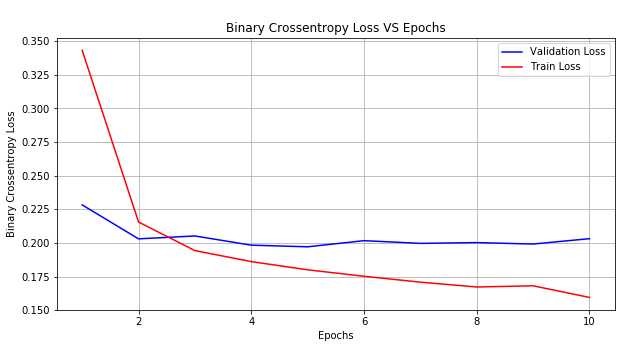

In [19]:
x = list(range(1,11))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

### Model 2- LSTM layer + Dropout (adam optimizer)

In [20]:
# truncate and/or pad input sequences
max_review_length = 300

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 300)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [21]:
from keras.layers import Dropout
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(vocab.keys())+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.6))

model.add(LSTM(100))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           2292064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,345,365
Trainable params: 2,345,365
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
history = model.fit(X_train, y_train, epochs = 20, batch_size=128, verbose=1,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/20
70000/70000 [==============================] - 551s 8ms/step - loss: 0.2828 - acc: 0.8905 - val_loss: 0.2034 - val_acc: 0.9179
Epoch 2/20
70000/70000 [==============================] - 559s 8ms/step - loss: 0.1957 - acc: 0.9250 - val_loss: 0.2011 - val_acc: 0.9219
Epoch 3/20
70000/70000 [==============================] - 550s 8ms/step - loss: 0.1769 - acc: 0.9328 - val_loss: 0.2013 - val_acc: 0.9217
Epoch 4/20
70000/70000 [==============================] - 551s 8ms/step - loss: 0.1615 - acc: 0.9394 - val_loss: 0.2043 - val_acc: 0.9213
Epoch 5/20
70000/70000 [==============================] - 550s 8ms/step - loss: 0.1523 - acc: 0.9430 - val_loss: 0.2138 - val_acc: 0.9210
Epoch 6/20
70000/70000 [==============================] - 548s 8ms/step - loss: 0.1431 - acc: 0.9462 - val_loss: 0.2166 - val_acc: 0.9207
Epoch 7/20
70000/70000 [==============================] - 548s 8ms/step - loss: 0.1357 - acc: 0.9487 - val_loss: 0.2142 - 

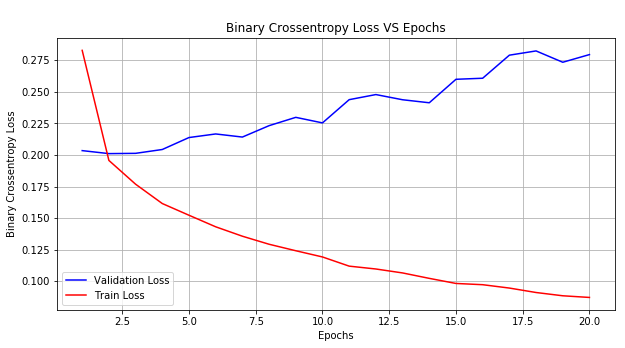

In [23]:
x = list(range(1,21))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

### Model3-LSTM with dropout 

In [25]:
# truncate and/or pad input sequences
max_review_length = 300

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 300)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [28]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(vocab.keys())+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.6))

model.add(LSTM(70))
model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 32)           2292064   
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 70)                28840     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 71        
Total params: 2,320,975
Trainable params: 2,320,975
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history = model.fit(X_train, y_train, epochs = 12, batch_size=128, verbose=1,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/12
70000/70000 [==============================] - 744s 11ms/step - loss: 0.2774 - acc: 0.8914 - val_loss: 0.2039 - val_acc: 0.9192
Epoch 2/12
70000/70000 [==============================] - 623s 9ms/step - loss: 0.1973 - acc: 0.9255 - val_loss: 0.2007 - val_acc: 0.9213
Epoch 3/12
70000/70000 [==============================] - 623s 9ms/step - loss: 0.1773 - acc: 0.9328 - val_loss: 0.2014 - val_acc: 0.9191
Epoch 4/12
70000/70000 [==============================] - 623s 9ms/step - loss: 0.1635 - acc: 0.9380 - val_loss: 0.2019 - val_acc: 0.9194
Epoch 5/12
70000/70000 [==============================] - 622s 9ms/step - loss: 0.1522 - acc: 0.9439 - val_loss: 0.2130 - val_acc: 0.9198
Epoch 6/12
70000/70000 [==============================] - 645s 9ms/step - loss: 0.1443 - acc: 0.9470 - val_loss: 0.2119 - val_acc: 0.9198
Epoch 7/12
70000/70000 [==============================] - 630s 9ms/step - loss: 0.1366 - acc: 0.9497 - val_loss: 0.2200 -

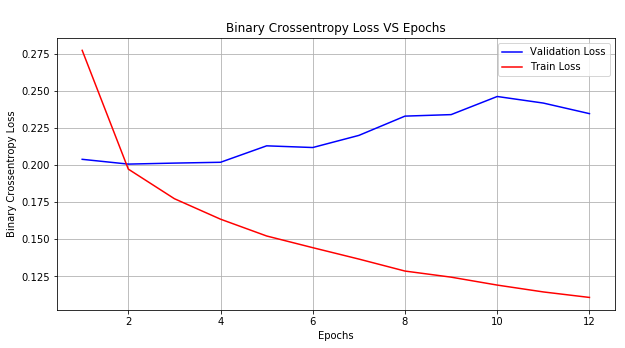

In [34]:
x = list(range(1,13))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

# Conclusion

In [37]:
from prettytable import PrettyTable
ptable = PrettyTable()
accuracy=[91.94,91.36,91.65]
impl=["Model1 with LSTM ", "Model2 with LSTM with dropout","Model3 with LSTM with dropout" ]
ptable.add_column("S.NO",[1,2,3])
ptable.add_column("Implementation",impl)
ptable.add_column(" Accuracy of model",accuracy)
print(ptable)

+------+-------------------------------+--------------------+
| S.NO |         Implementation        |  Accuracy of model |
+------+-------------------------------+--------------------+
|  1   |       Model1 with LSTM        |       91.94        |
|  2   | Model2 with LSTM with dropout |       91.36        |
|  3   | Model3 with LSTM with dropout |       91.65        |
+------+-------------------------------+--------------------+
